# Lecture 3 - Discretisation of the Radon Transform

# Contents

* The discrete Radon transform
* Sparse matrices
* Matrix-free implementation
* Assignments

# The Discrete Radon Transform


The Radon transform is defined as 

$$f(s,\theta) = \int_{-\infty}^\infty u\left(x(s,t), y(s,t)\right) \mathrm{d}t,$$

with

$$x(s,t) = s \cos \theta + t \sin \theta, \quad y(s,t) = s \sin \theta - t\cos\theta.$$

* Let $s \in [-1,1]$ and discretise the detector in $n_d$ cells with width $2/n_d$.
* Let $(x,y) \in [-1,1]^2$ and discretise the image in $n_x \times n_y$ pixels with size $2/n_x \times 2/n_y$.
* The contribution of the $j-th$ pixel to the $i-th$ detector element at angle $\theta$ is then given by 

$$a_{ij}(\theta) = \int_{-\infty}^\infty \phi_j\left(x(s_i,t), y(s_i,t)\right) \mathrm{d}t,$$

with $\phi_j(x,y)$ is supported on the $j-th$ pixel.

* The measurement along a single angle then leads to a matrix $A(\theta) \in \mathbb{R}^{n_d \times n_x \dot n_y}$

We can now easily compute the matrix elements for a given set of angles $\{\theta_k\}_{k=1}^{n_\theta}$ and define

$$A = \left( \begin{matrix} A(\theta_1) \\ A(\theta_2) \\ \vdots \\ A(\theta_k)\end{matrix}\right).$$

The vectorised discretised sinogram and image are then related via

$$\mathbf{f} = A\mathbf{u}.$$

## The line model

* The weights $a_{ij}$ represent the length of the intersection between the $j-th$ ray and the $i-th$ pixel.
* We can compute these efficiently by solving for $t$ from
$$x = s \cos \theta + t \sin \theta, \quad y = s \sin \theta - t\cos\theta,$$
where $s$ is given and $x,y$ are the grid lines.
* This yields an array of intersection points $\{t_i\}_i$ along the ray and $t_{i} - t_{i-1}$ gives the intersection length

In [19]:
import numpy as np

x = np.array([-1, -.5, 0, .5, 1])
y = np.array([-1, -.5, 0, .5, 1])

s = .1
theta = 1

tx = (x - s*np.cos(theta)) / np.sin(theta)
ty = -(y - s*np.sin(theta)) / np.cos(theta)
t = np.sort(np.concatenate((tx,ty)))

xi = s*np.cos(theta) + t*np.sin(theta)
yi = s*np.sin(theta) - t*np.cos(theta)


(-1.0, 1.0)

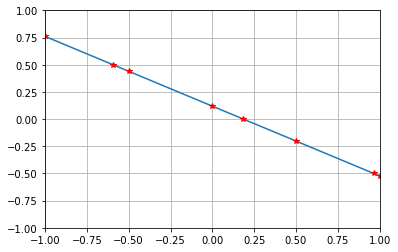

In [25]:
import matplotlib.pyplot as plt

ts = np.linspace(t[0],t[-1],100)
plt.plot(s*np.cos(theta) + ts*np.sin(theta),s*np.sin(theta) - ts*np.cos(theta))
plt.plot(xi,yi,'r*')
plt.grid(markevery=(1,1),which='both')
plt.xlim([-1,1])
plt.ylim([-1,1])

In [15]:
help(plt.grid)

Help on function grid in module matplotlib.pyplot:

grid(visible=None, which='major', axis='both', **kwargs)
    Configure the grid lines.
    
    Parameters
    ----------
    visible : bool or None, optional
        Whether to show the grid lines.  If any *kwargs* are supplied, it
        is assumed you want the grid on and *visible* will be set to True.
    
        If *visible* is *None* and there are no *kwargs*, this toggles the
        visibility of the lines.
    
    which : {'major', 'minor', 'both'}, optional
        The grid lines to apply the changes on.
    
    axis : {'both', 'x', 'y'}, optional
        The axis to apply the changes on.
    
    **kwargs : `.Line2D` properties
        Define the line properties of the grid, e.g.::
    
            grid(color='r', linestyle='-', linewidth=2)
    
        Valid keyword arguments are:
    
        Properties:
        agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3

# Sparse matrices

* Let $n_x = n_y = n$ and $n_d = n_\theta = n$.
* We can easily see that we only have $\mathcal{O}(n)$ non-zeros in each row of the matrix; so $\mathcal{O}(n^3)$ non-zeros in total
* It is not very attractive to store and compute with all the zero-entries explicitly

## Sparse matrix formats

# Matrix-free implementation

* For 3D applications, we'd end up with a matrix with $\mathcal{O}(n^4)$ non-zeros
* Using double precision, storage may take several Terabytes in practice ($n = 1000$).
* Can we instead compute the matrix elements on-the-fly?

* We can write a function to perform multiplication of $A$ by a given vector *implicitly*
* This avoids storage, but may induce some computational overhead
* We *cannot* access individual elements of the matrix easily
* We need to write a seperate function to multiply with the transpose of the matrix

## An example

Consider a finite-difference matrix

$$A = \left(\begin{matrix}-2 & 1& 0  & \ldots & \\ 1 & -2 & 1 & 0 \\ & \ddots & \ddots & \ddots & \\ 0 & \ldots &0 & 1 & -2 \end{matrix}\right).$$

The function would look like

```python 
def FD(u, n):
    v       = np.zeros(n)
    v[0]    = -2*u[0] + u[1]
    v[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    v[-1]   = u[-2] - 2*u[-1]
    
```

## Another example

Consider summing the elements of a vector

$$A = (1, 1, 1, \ldots, 1).$$

```python
def sum(u,n):
    return np.sum(u)
```

```python
def sum_transpose(v,n):
    u = v * np.ones(n)
```

# Assignments